<b></b>

<b>Summary: </b>Predicting gender from names using character level RNN

<b>Datasets: </b>https://www.kaggle.com/nltkdata/names , http://www.cs.cmu.edu/afs/cs/project/ai-repository/ai/areas/nlp/corpora/names/

<b>ref: </b>https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

In [1]:
import pandas as pd

names_data = pd.read_csv('datasets/gender_by_names/names.csv')

names_data.head()

,Name,Gender
0,Aamir,Male
1,Aaron,Female
2,Aaron,Male
3,Abagael,Female
4,Abagail,Female


In [2]:
len(names_data)

10132

#### Check the number of unique names
Even though we have 10132 entries in this dataset, the number of unique names is only 9543 as there are several names which apply to both genders (e.g. Aaron as seen above). 

In [3]:
len(names_data['Name'].unique())

9543

#### Remove the duplicate names
The drop_duplicates() function in pandas allows removal of duplicates. There is an option to keep either the first, last or none of the values values. Here, we randomly pick one of 'first' or 'last'. This will mean that a unisex name will be labeled as either male or female randomly

In [4]:
import random 

names_data = names_data.drop_duplicates(subset=['Name'], 
                                        keep=random.choice(['first', 'last']))
len(names_data)

9543

In [5]:
names_data.head()

,Name,Gender
0,Aamir,Male
2,Aaron,Male
3,Abagael,Female
4,Abagail,Female
5,Abbe,Female


#### Convert gender values to number using label encoding

In [6]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
names_data['Gender'] = le.fit_transform(names_data['Gender'])
names_data.head()

,Name,Gender
0,Aamir,1
2,Aaron,1
3,Abagael,0
4,Abagail,0
5,Abbe,0


#### Create a list containing the genders
These are the genders available in our dataset

In [7]:
genders=['Female', 'Male']

#### Getting all possible letters
This will allow us to create a one-hot-encoded tensor for the names

In [8]:
import string
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

#### Function to convert name in tensors 
This effectively performs one-hot-encoding

In [9]:
import torch

def name_to_tensor(name):
    name_in_tensor = torch.zeros(len(name), 1, n_letters)
    for i, letter in enumerate(name):
        name_in_tensor[i][0][all_letters.find(letter)] = 1
        
    return name_in_tensor

#### Check what names may look like when converted to tensors
You can see a(small) is first element and A(capital) is somewhere in between

In [10]:
name_to_tensor('a')

tensor([[[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.]]])

In [11]:
name_to_tensor('aA')

tensor([[[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.]],

        [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.]]])

#### Define the RNN
Explanation of the model below
https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html#creating-the-network

To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of each gender) and a next hidden state (which we keep for the next step).

* the <b>i2h</b> layer is an input-to-hidden layer while <b>i2o</b> is input-to-output <br /> 
* the <b>combined</b> layer performs the combination of the current input letter along with the value of the previous hidden layer


In [12]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)    
        output = self.i2o(combined)    
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


#### Create an RNN
We specify the number of hidden layers along with the output size

In [13]:
n_hidden = 128
n_genders= len(genders)

rnn = RNN(n_letters, n_hidden, output_size = n_genders)

#### Define parameters for training the model
* we perform 100,000 iterations which will ensure a thorough coverage of the 10,000 names in the dataset
* the loss function is negative log likelihood loss
* we initialize a learning rate of 0.005 which will decrease with each iteration

In [14]:
iterations = 100000

criterion = nn.NLLLoss()

learning_rate = 0.005

#### Convert a prediction to the string label for gender
We get a list of probabilities for each gender and then use that to return the 'Male' or 'Female' label depending on which gender had the higher probability

In [16]:
def output_to_gender (output):
    
    top_n, top_index = output.topk(1)
    pred_i = top_index[0].item()
    pred = genders[pred_i] 
    
    return pred

#### Import the random module
We will be picking names randomly from our dataset for which we will use the random module

In [15]:
import random

#### Perform the training 
* we pick a name randomly from the dataset and convert it to a tensor
* we get the actual label for that name
* the RNN is initialized with zero gradients
* for each character in the name:
 * we use the RNN to perform a prediction on letters of the name up to that character
* we calculate the loss based on the predicted and actual values of gender
* we perform a back propagation to recalibrate the weights in the NN
* we update the parameters of the NN by adding to them their gradient and subtracting the learning rate (to slow down the learning)

Finally, for every 5000th iteration, we print out the name, the prediction and the actual label along with the calculated loss

In [18]:
for iteration in range(1 , iterations +1):

    i = random.randint(0, len(names_data) - 1)
    
    name = names_data.iloc[i][0]
    name_in_tensor = name_to_tensor(name)
    
    gender = names_data.iloc[i][1]
    gender_in_tensor = torch.LongTensor([gender])
    
    hidden = rnn.initHidden()
    rnn.zero_grad()

    for i in range(name_in_tensor.size()[0]):
        output, hidden = rnn(name_in_tensor[i], hidden)

    loss = criterion(output, gender_in_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    if iteration% 5000 == 0:
        
        pred = output_to_gender(output)
        
        correct = '✓' if pred == genders[gender] else '✗ (%s)' % genders[gender]
        print('iters- %d %d%% (%s) Name- %s Gender- %s %s' % \
              (iteration, iteration/iterations*100, loss.item(), name, pred, correct))


iters- 5000 5% (0.6815771460533142) Name- Ellen Gender- Female ✓
iters- 10000 10% (0.06398488581180573) Name- Dulsea Gender- Female ✓
iters- 15000 15% (0.3441551625728607) Name- Ute Gender- Female ✓
iters- 20000 20% (0.018940361216664314) Name- Lynea Gender- Female ✓
iters- 25000 25% (0.3014815151691437) Name- Maude Gender- Female ✓
iters- 30000 30% (0.2008412778377533) Name- Lessie Gender- Female ✓
iters- 35000 35% (0.3213464617729187) Name- Clari Gender- Female ✓
iters- 40000 40% (0.005412688013166189) Name- Shauna Gender- Female ✓
iters- 45000 45% (2.198755979537964) Name- Aguste Gender- Female ✗ (Male)
iters- 50000 50% (0.44527387619018555) Name- Darwin Gender- Male ✓
iters- 55000 55% (0.19184574484825134) Name- Sonnnie Gender- Female ✓
iters- 60000 60% (0.05462459474802017) Name- Mmarianne Gender- Female ✓
iters- 65000 65% (0.5907812118530273) Name- Sang Gender- Male ✓
iters- 70000 70% (0.5678301453590393) Name- Vail Gender- Male ✓
iters- 75000 75% (0.23434269428253174) Name- Veri

#### Perform a test using 10,000 randomly selected names
We peform steps similar to what was done in training. 
* pick a name at random, conver to tensor
* convert the label to a tensor
* initialize the RNN's hidden layers
* make a prediction for each additional character of the name and then get the final prediction after all the characters have been fed in

After this, we create lists with the real and predicted values of gender. We will use these to plot a confusion matrix to check the accuracy. 

In [19]:
n_confusion = 10000

prediction=[]
actual = []

for _ in range(n_confusion):

    i = random.randint(0, len(names_data) - 1)
    
    name = names_data.iloc[i][0]
    name_in_tensor = name_to_tensor(name)
    
    gender_idx = names_data.iloc[i][1]
    gender_in_tensor = torch.LongTensor([gender_idx])
        
    hidden = rnn.initHidden()

    for j in range(name_in_tensor.size()[0]):
        output, hidden = rnn(name_in_tensor[j], hidden)
    
    pred = output_to_gender(output)
    
    prediction.append(pred)
    actual.append(genders[gender_idx])

#### Install pandas_ml
This is needed for the confusion matrix

In [ ]:
!pip install pandas_ml

In [20]:
from pandas_ml import ConfusionMatrix
import numpy as np

#### Convert the actual and predicted values to a numpy array
We need to do this to convert the lists to a set of boolean values which is required for a binary confusion matrix

In [21]:
np_prediction = np.array(prediction)
np_actual = np.array(actual)

#### Create a confusion matrix
Here, Female==True and Male==False. We can also gauge the accuracy from the values here

In [22]:
cm = ConfusionMatrix(np.where(np_prediction == 'Female', True, False), 
                     np.where(np_actual == 'Female', True, False))
cm

Predicted  False  True  __all__
Actual                         
False       2560   909     3469
True         842  5689     6531
__all__     3402  6598    10000

#### Plot the confusion matrix

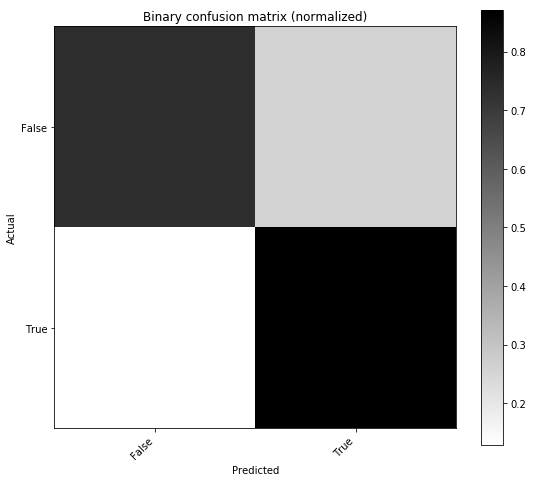

In [23]:
import matplotlib.pyplot as plt
cm.plot(normalized=True)
plt.show()